In [360]:
#IMPORT STATEMENTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **LOAD THE DATASET**

In [361]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin1')
# encoding=latin1 is used to resolve error
#UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 606-607: invalid continuation byte

In [362]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# **1) Data Cleaning**

In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


# **Delete Unwanted Columns**

In [364]:
# Delete last three cloumns as they dont contribute much
df.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"],inplace=True)

In [365]:
df.head(2)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


# **Rename the columns**

In [366]:
df.columns=["target","sms"]

In [367]:
df.head(2)

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


# **Changing the target values to number**

In [368]:
df["target"]=df["target"].replace("ham",0)
df["target"]=df["target"].replace("spam",1)

/tmp/ipykernel_30/1517355091.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["target"]=df["target"].replace("spam",1)


In [369]:
df.head(2)

,target,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...


# **Check Null Values**

In [370]:
df.isnull().sum()

target    0
sms       0
dtype: int64

# **Check for Duplicate Values**

In [371]:
df.duplicated().sum()

403

In [372]:
len(df)

5572

In [373]:
#remove duplicates
df=df.drop_duplicates()
df.shape

(5169, 2)

# **2) EDA [Exploratory Data Analysis]**

**Check the ratio of Spam and Ham messages**

In [374]:
df["target"].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

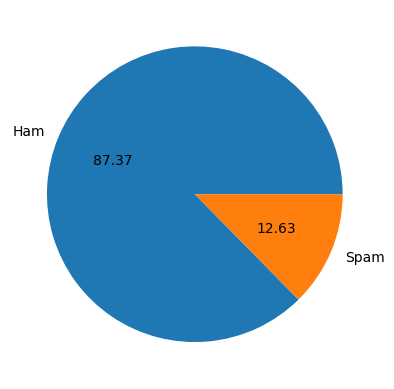

In [375]:
plt.pie(df["target"].value_counts(),labels=["Ham","Spam"],autopct="%.2f")
plt.show()

We can observe that the data is imbalanced

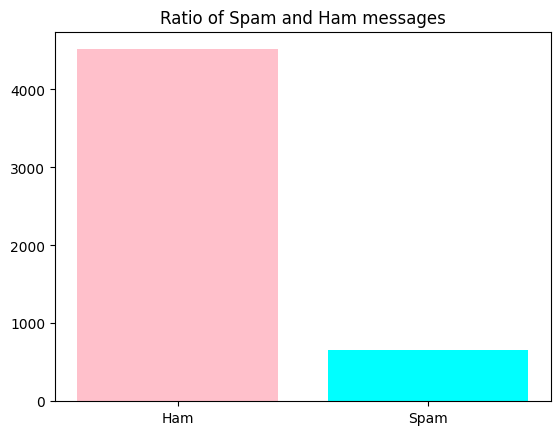

In [376]:
X=["Ham","Spam"]
Y=df["target"].value_counts()
plt.bar(X,Y,color=["pink","cyan"])
plt.title("Ratio of Spam and Ham messages")
plt.show()

**Word Cloud to check the word with max frequency that appears in Spam**

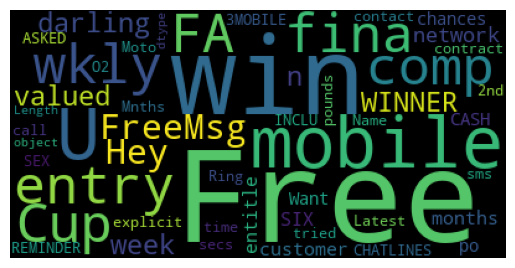

In [377]:
from wordcloud import WordCloud
text=str(df[df["target"]==1]["sms"])

# Generate a word cloud
wordcloud = WordCloud().generate(text)

# Display the word cloud
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


# **2) Data Preprocessing**

In [378]:
# REMOVE URL's.
import re
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

In [379]:
#REMOVE PUNCTUATIONS
import re

def remove_punctuations(text):
    text=re.sub(r"[^A-Za-z0-9\s]","",text)
    return text
    

In [380]:
#REMOVE STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stopword(text):
    stop_words = stopwords.words('english')  # Specify 'english' for English stopwords
    temp_text = word_tokenize(text)

    for word in temp_text:
        if word in stop_words:
            text=text.replace(word,"")
    return text

In [381]:
from nltk.stem import PorterStemmer
def Stemming(text):
    ps = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_words = []
    for token in tokens:
        stemmed_token = ps.stem(token)
        stemmed_words.append(stemmed_token)
    return ' '.join(stemmed_words)

In [382]:
def transform(text):
    text=text.lower()
    text=remove_urls(text)
    text=remove_punctuations(text)
    text=remove_stopword(text)
    text=Stemming(text)

    return text

    

In [383]:
df["transformed"]=df["sms"].apply(transform)
df.head(2)

,target,sms,transformed
0,0,"Go until jurong point, crazy.. Available only ...",go jurong pot crazi avail bugi n great world l...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni


# **Text Vectorization**

In [384]:
#Bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
X=cv.fit_transform(df["transformed"]).toarray() 
#0.99 precison   but is it is classifying 20 spam as not spam(False Negative)

In [385]:
#TF IDF

from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
X=tf.fit_transform(df["transformed"]).toarray()
#NO False Negative

# **SMOTE**

In [386]:
from imblearn.over_sampling import SMOTE

In [387]:
Y=df["target"]

In [388]:
# Apply SMOTE after transforming text
smote = SMOTE(random_state=0)
X,Y=smote.fit_resample(X, Y)

In [389]:
import joblib
joblib.dump(tf,"tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [390]:
X.shape

(9032, 9720)

# **Splitting**

In [391]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20,random_state=0)

In [392]:
print(len(X_train))
print(len(X_test))

7225
1807


# **MODEL BUILDING**

# **1) Benoulli Naive Bayes**

In [393]:
from sklearn.naive_bayes import BernoulliNB
bnb_model=BernoulliNB()
bnb_model.fit(X_train,Y_train)

BernoulliNB()

In [394]:
#since data is not balanced, we will not rely on just accuracy, precision would be a better metric
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

Y_pred=bnb_model.predict(X_test)

accuracy=accuracy_score(Y_test,Y_pred)
precision=precision_score(Y_test,Y_pred)
recall=recall_score(Y_test,Y_pred)
f1=f1_score(Y_test,Y_pred)

print("Accuracy",accuracy)
print("Precision",precision)
print("Recall",recall)
print("F1 Score",f1)

Accuracy 0.9889319313779745
Precision 1.0
Recall 0.9780701754385965
F1 Score 0.9889135254988913


Text(0.5, 1.0, 'Confusion Matrix for Spam Detection')

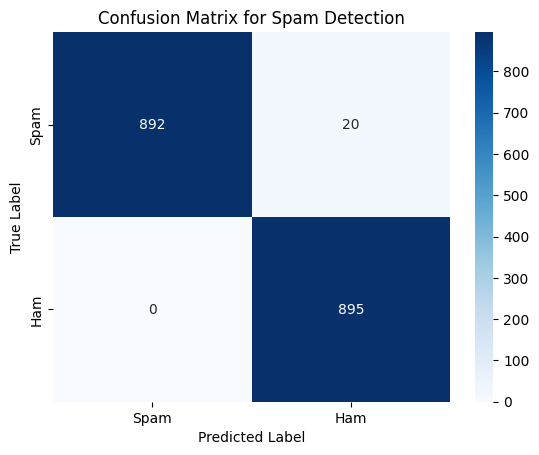

In [395]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix with custom labels
cm = confusion_matrix(Y_test, Y_pred, labels=[1, 0])

# Plot heatmap with labeled axes
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Spam", "Ham"], yticklabels=["Spam", "Ham"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Spam Detection")

# **2)Multinomial Naive Bayes**

In [396]:
from sklearn.naive_bayes import MultinomialNB

mnb_model=MultinomialNB()
mnb_model.fit(X_train,Y_train)

MultinomialNB()

In [397]:
Y_pred=mnb_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
print("Accuracy",accuracy)
print("Precision",precision)
print("Recall",recall)
print("F1-Score",f1)

Accuracy 0.9833978970669618
Precision 0.9772727272727273
Recall 0.9901315789473685
F1-Score 0.9836601307189543


Text(50.722222222222214, 0.5, 'True Label')

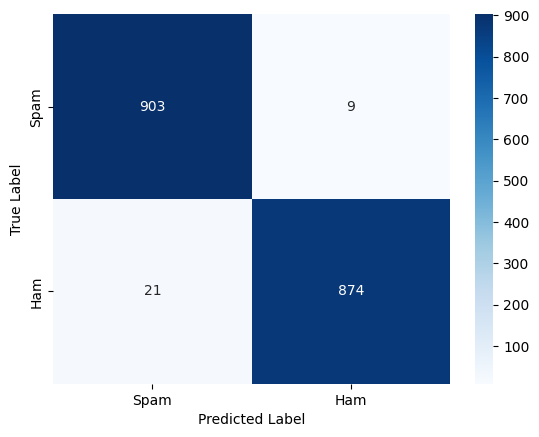

In [398]:
# Generate confusion matrix with custom labels
cm = confusion_matrix(Y_test, Y_pred, labels=[1, 0])

# Plot heatmap with labeled axes
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Spam", "Ham"], yticklabels=["Spam", "Ham"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# **3)Gaussian Naive Bayes**

In [399]:
from sklearn.naive_bayes import GaussianNB
gnb_model=GaussianNB()
gnb_model.fit(X_train,Y_train)

GaussianNB()

In [400]:
Y_pred=gnb_model.predict(X_test)

accuracy=accuracy_score(Y_test,Y_pred)
precision=precision_score(Y_test,Y_pred)
recall=recall_score(Y_test,Y_pred)
f1Score=f1_score(Y_test,Y_pred)

print(accuracy)
print(precision)
print(recall)
print(f1Score)

0.9457664637520753
0.902970297029703
1.0
0.9490114464099897


Text(50.722222222222214, 0.5, 'True Label')

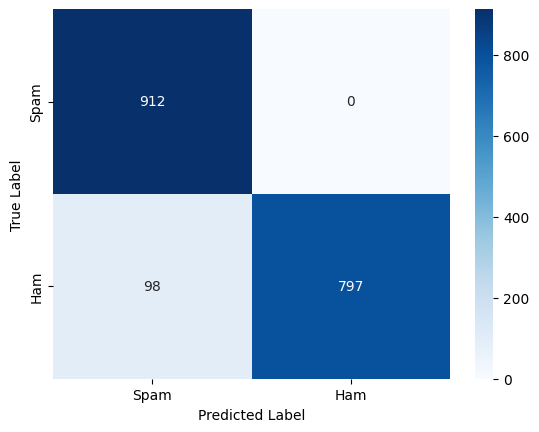

In [401]:
# Generate confusion matrix with custom labels
cm = confusion_matrix(Y_test, Y_pred, labels=[1, 0])

# Plot heatmap with labeled axes
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Spam", "Ham"], yticklabels=["Spam", "Ham"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# **Save the model**

In [402]:
import joblib
joblib.dump(bnb_model,"bnb_model.pkl")

['bnb_model.pkl']

In [403]:
import joblib
joblib.dump(mnb_model,"MNB_model.pkl")

['MNB_model.pkl']